In [2]:
import geopandas as gpd
import pandas as pd




In [15]:
# load duration data

duration_orig = gpd.read_file('../data/derived_data/flats_duration.gpkg')
duration_iso = gpd.read_file('../data/derived_data/flats_duration_iso.gpkg')
duration_ors = gpd.read_file('../data/derived_data/flats_duration_ors.gpkg')


In [23]:
# Calculate population weighted duration for each dataset
# Formula: sum(duration * population) / sum(population)

# For duration_orig
orig_weighted = (duration_orig['duration'] * duration_orig['est_pop']).sum() / duration_orig['est_pop'].sum()

# For duration_iso
iso_weighted = (duration_iso['duration_min'] * duration_iso['est_pop']).sum() / duration_iso['est_pop'].sum()

# For duration_ors
ors_weighted = (duration_ors['duration'] * duration_ors['est_pop']).sum() / duration_ors['est_pop'].sum()

# Convert to min:sec format
def format_time(minutes):
    mins = int(minutes)
    secs = int((minutes - mins) * 60)
    return f"{mins}:{secs:02d}"

print(f"Original weighted duration: {format_time(orig_weighted)} min:sec")
print(f"Isochrone weighted duration: {format_time(iso_weighted)} min:sec")
print(f"ORS weighted duration: {format_time(ors_weighted)} min:sec")

# Calculate population outside 10-minute range for each dataset
orig_outside = duration_orig[duration_orig['duration'] > 10]['est_pop'].sum()
iso_outside = duration_iso[duration_iso['duration_min'] > 10]['est_pop'].sum()
ors_outside = duration_ors[duration_ors['duration'] > 10]['est_pop'].sum()

print(f"\nPopulation outside 10-minute range:")
print(f"Original: {orig_outside:.0f}")
print(f"Isochrone: {iso_outside:.0f}")
print(f"ORS: {ors_outside:.0f}")

# Calculate total population
total_pop = duration_orig['est_pop'].sum()

# Calculate coverage percentage for each dataset
orig_coverage = ((total_pop - orig_outside) / total_pop) * 100
iso_coverage = ((total_pop - iso_outside) / total_pop) * 100
ors_coverage = ((total_pop - ors_outside) / total_pop) * 100

print(f"\nPopulation coverage within 10-minute range:")
print(f"Original: {orig_coverage:.1f}%")
print(f"Isochrone: {iso_coverage:.1f}%")
print(f"ORS: {ors_coverage:.1f}%")

# Create a DataFrame with the comparison results
comparison_df = pd.DataFrame({
    'Method': ['Current Situation', 'Isochrones+Clustering', 'ORS Routing+Clustering'],
    'Population Outside 10min': [orig_outside, iso_outside, ors_outside],
    'Coverage (%)': [orig_coverage, iso_coverage, ors_coverage],
    'Average Walking Time (min)': [orig_weighted, iso_weighted, ors_weighted],
    'Number of additional RCPs': [0, 10, 12]
})

# Round numeric columns
comparison_df['Population Outside 10min'] = comparison_df['Population Outside 10min'].round(0)
comparison_df['Coverage (%)'] = comparison_df['Coverage (%)'].round(1)
comparison_df['Average Walking Time (min)'] = comparison_df['Average Walking Time (min)'].round(2)

print(comparison_df)



Original weighted duration: 4:07 min:sec
Isochrone weighted duration: 3:57 min:sec
ORS weighted duration: 3:52 min:sec

Population outside 10-minute range:
Original: 9609
Isochrone: 4301
ORS: 2079

Population coverage within 10-minute range:
Original: 97.8%
Isochrone: 99.0%
ORS: 99.5%
                   Method  Population Outside 10min  Coverage (%)  \
0       Current Situation                    9609.0          97.8   
1   Isochrones+Clustering                    4301.0          99.0   
2  ORS Routing+Clustering                    2079.0          99.5   

   Average Walking Time (min)  Number of additional RCPs  
0                        4.12                          0  
1                        3.96                         10  
2                        3.87                         12  


In [24]:
comparison_df

,Method,Population Outside 10min,Coverage (%),Average Walking Time (min),Number of additional RCPs
0,Current Situation,9609.0,97.8,4.12,0
1,Isochrones+Clustering,4301.0,99.0,3.96,10
2,ORS Routing+Clustering,2079.0,99.5,3.87,12


In [ ]:


import numpy as np
import matplotlib.pyplot as plt

# Define comparison of methods data
methods = ['Current Situation', 'Isochrones+Clustering', 'ORS Routing+Clustering', 'Linear Optimization']
people_outside = [9138, 3767, 1933, 0]  # Replace 'None' with 0
coverage = [98.9, 99.2, 99.6, 0]        # Replace 'None' with 0
walking_times = [4.1, 3.93, 3.85, 0]    # Replace 'None' with 0
new_rcps = [0, 10, 12, 0]               # Replace 'None' with 0

# Set dark theme style
plt.style.use('dark_background')

# Define blue color palette
colors = ['#1f77b4', '#2b94d1', '#37b0ee']

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor('#1a1a1a')

# Plot 1: People outside the network
ax1.bar(methods[0:3], people_outside[0:3], color=colors)
ax1.set_title('People Outside Network', pad=15, fontsize=12)
ax1.set_ylabel('Number of People', fontsize=11)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.set_facecolor('#1a1a1a')

# Plot 2: Walking time
ax2.bar(methods[0:3], walking_times[0:3], color=colors)
ax2.set_title('Population Weighted Walking Time', pad=15, fontsize=12)
ax2.set_ylabel('Minutes', fontsize=11)
ax2.tick_params(axis='x', rotation=45, labelsize=10)
ax2.set_facecolor('#1a1a1a')

# Plot 3: Number of New RCPs
ax3.bar(methods[1:3], new_rcps[1:3], color=colors)
ax3.set_title('Number of New RCPs', pad=15, fontsize=12)
ax3.set_ylabel('Count', fontsize=11)
ax3.tick_params(axis='x', rotation=45, labelsize=10)
ax3.set_facecolor('#1a1a1a')

# save plot
plt.savefig('../data/plots/method_comparison.png', dpi=400, bbox_inches='tight')

plt.tight_layout()
plt.show()

/tmp/ipykernel_15361/3268658060.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Population Outside 10min', data=comparison_df, ax=ax1, palette=colors)
/tmp/ipykernel_15361/3268658060.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Coverage (%)', data=comparison_df, ax=ax2, palette=colors)
/tmp/ipykernel_15361/3268658060.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Average Walking Time (min)', data=comparison_df, ax=ax3, palette=colors)


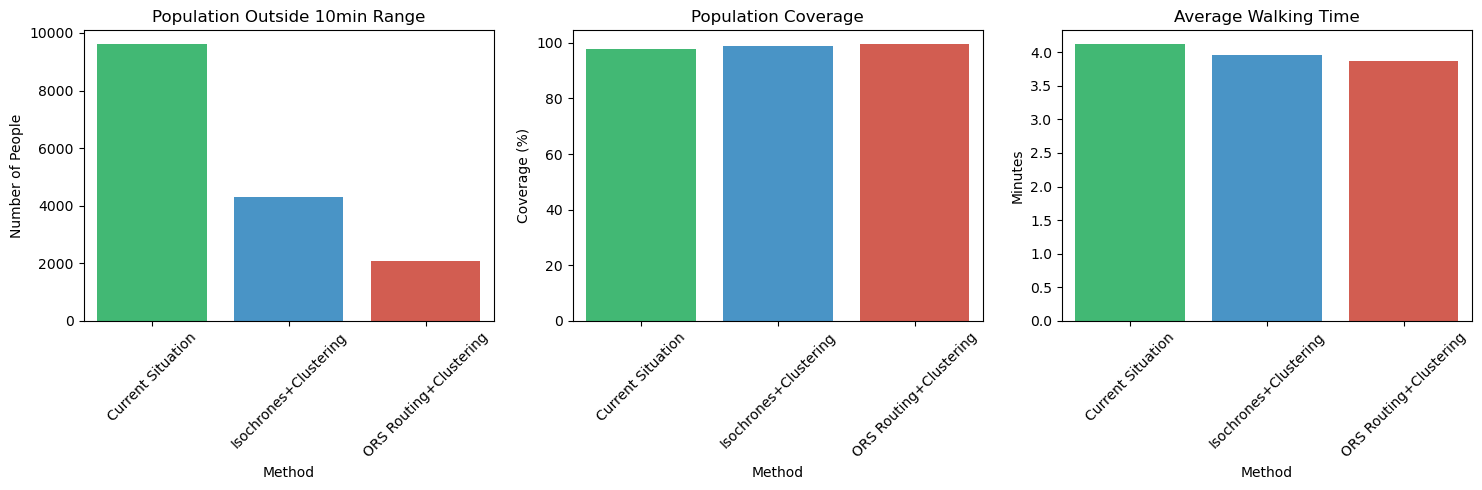

In [27]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set style
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Color palette
colors = ['#2ecc71', '#3498db', '#e74c3c']

# Plot 1: Population Outside 10min
sns.barplot(x='Method', y='Population Outside 10min', data=comparison_df, ax=ax1, palette=colors)
ax1.set_title('Population Outside 10min Range')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Number of People')

# Plot 2: Coverage
sns.barplot(x='Method', y='Coverage (%)', data=comparison_df, ax=ax2, palette=colors)
ax2.set_title('Population Coverage')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Coverage (%)')

# Plot 3: Average Walking Time
sns.barplot(x='Method', y='Average Walking Time (min)', data=comparison_df, ax=ax3, palette=colors)
ax3.set_title('Average Walking Time')
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylabel('Minutes')

plt.tight_layout()
plt.show()

In [ ]:

# Calculate people brought in per new RCP
people_per_rcp = [people_brought_in[i]/new_rcps[i] if new_rcps[i] != 0 else 0 for i in range(1,3)]

# Create a new figure
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')

# Plot the data
plt.bar(methods[1:3], people_per_rcp, color=colors[0:2])

# Customize the plot
plt.title('People Brought Into Network per New RCP')
plt.ylabel('Number of People per RCP')
plt.xticks(rotation=45)
plt.gca().set_facecolor('#1a1a1a')
plt.gca().tick_params(colors='white')plt.style.use('seaborn')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.title('People Brought Into Network per New RCP', color='white')
plt.ylabel('Number of People per RCP', color='white')
plt.xticks(color='white')
plt.tight_layout()

# Save the plot
plt.savefig('../data/plots/derived_data/people_brought_in_per_rcp.png', dpi=400, bbox_inches='tight', facecolor='#1a1a1a')

# Show the plot
plt.show()

In [11]:
duration_orig
duration_iso
duration_ors

,egid,est_pop,nearest_rcp_id,duration,impact,impact_log,weighted_time,geometry
0,140002.0,7.636364,sa73708,5.03,38.410909,3.674043,38.410909,POINT (8.54443 47.37592)
1,140005.0,0.967742,sa73708,5.09,4.925806,1.779317,4.925806,POINT (8.54416 47.37644)
2,140006.0,3.387097,sa73708,4.41,14.937097,2.768650,14.937097,POINT (8.54419 47.37583)
3,140007.0,3.387097,sa73708,4.73,16.020968,2.834446,16.020968,POINT (8.54419 47.37590)
4,140008.0,2.419355,sa73708,4.70,11.370968,2.515352,11.370968,POINT (8.54413 47.37602)
...,...,...,...,...,...,...,...,...
36727,302066607.0,4.500000,sa42901,6.21,27.945000,3.365397,27.945000,POINT (8.49190 47.36619)
36728,302066608.0,4.500000,sa42901,6.34,28.530000,3.385407,28.530000,POINT (8.49183 47.36622)
36729,302067118.0,3.783784,None,1.94,7.340541,2.121128,32.805405,POINT (8.47997 47.38155)
36730,302067484.0,2.925000,sa42971,1.35,3.948750,1.599135,3.948750,POINT (8.56073 47.36000)
